# Demo of using PySINDy with Hydrogym output

See `examples/pysindy/run-natural.py` for the code used to generate the lift/drag coefficients.  In this case we used the "natural" flow (i.e. without actuation).  We could also force the flow and use SINDy+c to identify a low-dimensional model including the effect of the input.

This notebook follows the approach in ["Sparse reduced-order modeling: Sensor-based dynamics to full-state estimation"](https://arxiv.org/abs/1706.03531) where the authors use time-series measurements of the lift coefficient to identify a a cubic second-order model for the dynamics of the cylinder wake.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
mpl.rc("figure", figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

data_dir = "../examples/pysindy/output"

In [2]:
# Numerical differentiation for lift coefficient
diff = ps.SINDyDerivative(kind="finite_difference", k=2)

In [3]:
# Load the results of the transient simulation
data = np.loadtxt(f"{data_dir}/results.dat")

start_idx = 1000  # Truncate noise used to initialize transient sim
t = data[start_idx:, 0]
CL, CD = data[start_idx:, 1], data[start_idx:, 2]

# Use numerical differentiation to estimate the first derivatives of lift
#   to be used as a secondary state variable
CL_dot = diff(CL, t)

luatex: /opt/anaconda3/lib/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libpoppler.so.73)


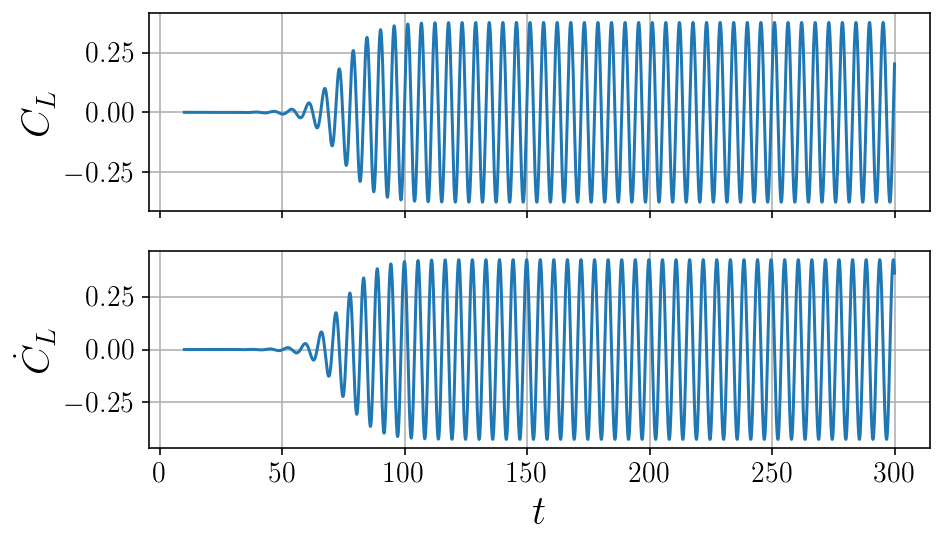

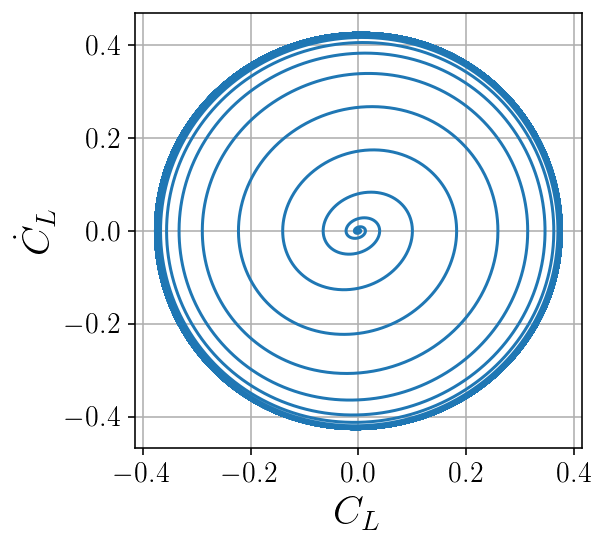

In [4]:
# Time series of lift and derivative
fig, axs = plt.subplots(2, 1, figsize=(7, 4), sharex="col")
axs[0].plot(t, CL)
axs[0].grid()
axs[0].set_ylabel(r"$C_L$")

axs[1].plot(t, CL_dot)
axs[1].grid()
axs[1].set_ylabel(r"$\dot{C}_L$")

axs[-1].set_xlabel(r"$t$")
plt.show()

# Phase portrait of (CL, CL_dot)
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

With the data loaded and pre-processed we can use PySINDy to identify a low-dimensional model that predicts the evolution of the lift coefficient.  See the [PySINDy documentation](https://pysindy.readthedocs.io/en/latest/) for more detail on the use of the PySINDy package

In [5]:
X = np.stack((CL, CL_dot), axis=-1)  # First column is x, second is y

differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.01)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "dx"],
)
model.fit(X, t=t)
model.print()

(x)' = 1.000 dx
(dx)' = -1.149 x + 0.205 dx + -0.988 x^3 + -1.764 x^2 dx + -0.650 x dx^2 + -1.047 dx^3


Note the quasilinear Van der Pol-like structure generating the unstable fixed point and oscillatory limit cycle.  The identified model _almost_ matches this structure:

$$
\ddot{x} + \mu A(x, \dot{x}) \dot{x} - k A(x, \dot{x}) x = 0, \qquad A(x, \dot{x}) = (\omega_0 x)^2 + \dot{x}^2
$$

In [6]:
# Evaluate the identified ODE
X_sim = model.simulate(X[0], t=t)

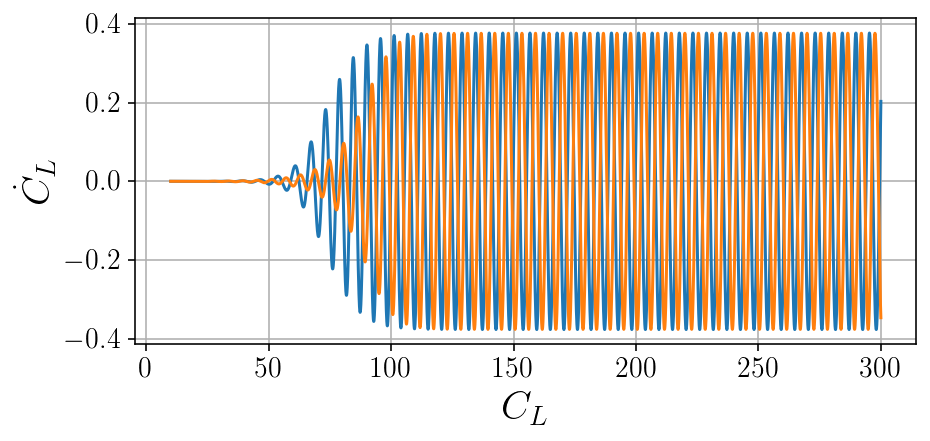

In [7]:
# Predicted time series of lift
plt.figure(figsize=(7, 3))
plt.plot(t, CL)
plt.plot(t, X_sim[:, 0])
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

Because of phase drift in the early transient stage the long-term forecast is inaccurate.  However, the low-dimensional model matches the phase portrait of the DNS almost perfectly, demonstrating that the estimates of the "flow field" governing the dynamical systems trajectories are good.

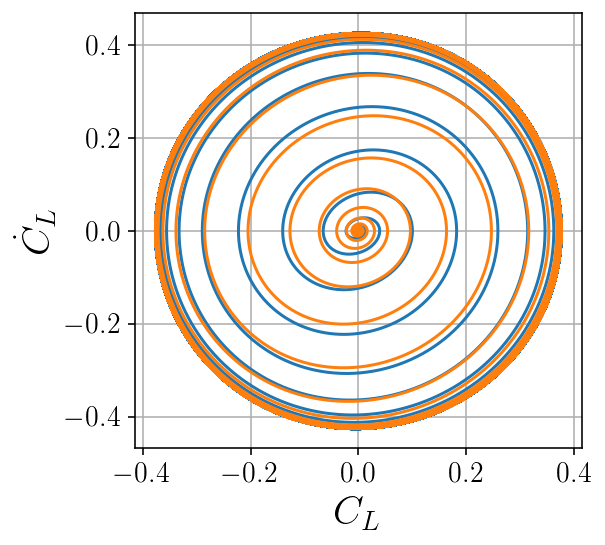

In [9]:
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.plot(X_sim[:, 0], X_sim[:, 1])
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()